# Path Integral Montecarlo


## Setup
This first part of the code is used to set up the input parameters for the ***code***. 

### List of corrections to the previous code
    
   1. Added __exchange update__
   2. **Changed displacement constant** for a **vector variable** initialized as h = [2,1,.08]. It makes sense, since the tree dimensions are at a different scale. 
   3. Created **look-up tables** where the potentials are saved in a refined grid
   4. **Sweep**:
       - Created new vectorized form of sweep. Instead sweeping one path at the time, it moves randomly several time components before accepting the sweep (I still need to include vectorized V_field to make it work properly)
       - Removed definitions from the method code. They were making the algorithm work slowly
       - By having a list of the action for every site in the path, we could avoid submitting doing the computations twice at each sweep. 
   5. **Vectorized potentials** (Any non-included potential already admits vectorization)
       - V_step 
       - ee - electron-electron interaction
       - V_hrl
       - V_doubledot
       - double_H0
       - V_HOld 
       - V_het
   6. **Find_action** 
        a) 100 times more efficient with vectorization
        b) Modified representation of time derivative (increased precision)
   7. Included **3D plots** of HRL potential
   8. Included changes in methods for interpolation ( from 'linear' to 'nearest neighbors'). 50% faster. Slight change at each computation in the third significant figure. *(not necessary with the look-up tables)*
    

### Questions
   - Do you have result for the exchange coupling to make comparisons?
   - How are we going to sort the sign problem?
    
### Ideas
   - Create a main function could give legibility to the code. General constants will be removed to avoid errors. 
   - Creating  a voltage function that could stand several modifications to the Hamiltonian depending on the desired code. This should be a simple way to add more flexibility to the program. 
   - It is necessary to implement periodic boundary conditions in order to avoid random paths getting out of the region where the HRL potential is defined. (Having second thoughts. It is unlikely that the paths could escape from the given region. However,  )
   - Random sampling kinetic energy as a Gaussian distribution could help improving the efficiency of the algorithm
   - We can implement a vectorized displacement just a in the center of mass sweep in worm PIMC paper
   - No need to compute old variables at each sweep. Save them in a vector and modify them when the sweep is accepted. (Experiment showed a decrease in runtime by 30%)
   - As far as I observe, the new implementation of the code, which promises to be 130 times faster, is more similar to the worm algorithm, than to the previous idea of it. Wouldn't it be better to use the already implement PIMC- Del Maestro's code? If not, my suggestion is to create a code that at be end would integrate the ideas of worm algorithms. ** The worm code specializes on bosonic systems with a large number of particles. This is not our case ** 




    


In [64]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu May 16 17:50:33 2019

@author: SQUANCHY-MC
"""
%matplotlib notebook
import numpy as np
from scipy.interpolate import RegularGridInterpolator as rgi
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor
import concurrent.futures
# RC - params . Better plots
def SetPlotParams():
    '''
     Inputs:
     Return:
    '''
    plt.rcParams.update({'font.size': 25})
    plt.rc("text", usetex = True)
    plt.rc("font", family = "serif")
    plt.rcParams['figure.subplot.hspace'] = 0.3
    plt.rcParams['figure.subplot.wspace'] = 0.1
    plt.rcParams['lines.linewidth'] = 3
    plt.rcParams['axes.formatter.limits'] = -3 , 3
    plt.rc('xtick.major', pad = 1)
    plt.rc('ytick.major', pad = 1)
    plt.rcParams['axes.labelpad'] = 15
    plt.rcParams['axes.formatter.use_mathtext'] = False
    plt.rcParams['figure.autolayout'] = True
    # plt.rcParams['figure.figsize'] =  8.3, 6.8
    plt.rcParams['figure.figsize'] =  6.8, 8.3
# %%
SetPlotParams()


## List of Constants

In [2]:


"""Parameters, units: ueV, nm, ns"""
print('Setting initial constants')
#N = 80 #time_steps and number of tried changes during one sweep.
num_path = 1000 #number of sweeps
print('num_paths = ', num_path)

#beta = 0.1 # imaginary total time? (/hbar?)
tau = 10 ** (-6) #ns
print('tau = ', tau, '(ns)')



interaction = 1 # Turn on/off electron-electron interaction (1 or 0)
h = np.array([1.2,.8,.1])
print('Displacement vector (h) =', h , 'nm')

eec = 1.23*10**5
print('Electron-electron coupling constant (eec) =', eec, 'ueV')
me = 5.686 * 10 **(-6) # ueV ns^2/nm^2 - electron mass
print('me = ', repr(np.round(me,9)), 'ueV*ns^2/nm^2' )
mass = 1 # Effective mass on/off

if mass == 1:
        meff= 0.2 * me #effective electron mass in Silicon
        ml = 0.98 * me #effective mass in longitudinal k-direction
        mt = 0.19 * me #effective mass in transverse k-direction
        mx = mt #effective mass in x-direction
        my = mt #effective mass in y-direction
        mz = ml #effective mass in z-direction
        m = np.array([mx,my,mz])
        print('Effective mass vector (m) = ', m,'*me' )
else:
        print('No Mass')

pot_step = 3 * 10**6 #ueV - Si/SiO2 interfac
print('Step voltage height (pot_step) = ', pot_step,' $ueV$' )
        
        
# %%

hbar = 0.6582 # ueV * ns
a = 0.543 #nm - lattice constant in silicon

w = 4000/hbar
q = 10**6 # ueV
lamda = 0.5 * hbar**2 / me
r_0 = np.sqrt(hbar / (me*w))

E_z = 2 * 10**3 #ueV/nm - Electric field in z direction

# %%

# a=10
slope = E_z
V = pot_step
x_0 = 1.5*r_0

# V_field = V_hrl

print('Lattice constant (a)=', a, 'nm')

HRL_Potential = 'old_UNSW4_1st withBG TEST ephiQWM UNSW4_1st structure 2nm 800x800 - 10-4-12-4.npz'
# HRL_Potential = 'UNSW4_1st withBG TEST ephiQWM for VX1_1V UNSW4_1st structure 2nm 800x800 - 10-4-12-4.npz'
print('Setting HRL potential VX1 =1V' )

Setting initial constants
num_paths =  1000
tau =  1e-06 (ns)
Displacement vector (h) = [1.2 0.8 0.1] nm
Electron-electron coupling constant (eec) = 123000.0 ueV
me =  5.686e-06 ueV*ns^2/nm^2
Effective mass vector (m) =  [1.08034e-06 1.08034e-06 5.57228e-06] *me
Step voltage height (pot_step) =  3000000  $ueV$
Lattice constant (a)= 0.543 nm
Setting HRL potential VX1 =1V


## Methods for path generation, crossings and staying

In [3]:
def generate_path(N,dot):
    '''Generates random paths. If uncommented the first part, it maps the first path inside the first dot, and the second path in the second dot
    This is not necessary in the last implementations
       inputs: N- number of time beads in the path
               dot- 0,1
       output: random path'''
    
    if dot == 1:
        pathx = np.random.uniform(-60,-20,N)
    else:
        pathx = np.random.uniform(-45,5,N)
#     pathx = np.random.uniform(-60,5,N)
    
    pathy = np.random.uniform(-12,12,N)
    pathz = np.random.uniform(-2,-0,N)
    path = np.array([pathx,pathy,pathz])
    
    path[:,-1] = np.copy(path[:,0])
    Perm = +1
    return path , Perm

def generate_paths_N_crossings(N, crossings):
    '''Generates random paths of 2 electrons with a defined number of crossings'''
    pathx1 = np.zeros(N) 
    pathx2 = np.zeros(N) 
    
    arr = np.arange(N)
    np.random.shuffle(arr)
    List= np.sort(arr[:crossings])
    CrossingPoints = np.zeros(crossings+2)
    CrossingPoints[0] = 0
    CrossingPoints[-1] = N
    CrossingPoints[1:-1] = List
    CrossingPoints = CrossingPoints.astype(int)

    for i in range(crossings+1):
        if i%2 == 0:
            pathx1[CrossingPoints[i]:CrossingPoints[i+1]] = np.random.uniform(-60,-20,CrossingPoints[i+1]-CrossingPoints[i])
            pathx2[CrossingPoints[i]:CrossingPoints[i+1]] = np.random.uniform(-45,5,CrossingPoints[i+1]-CrossingPoints[i])
        else:
            pathx1[CrossingPoints[i]:CrossingPoints[i+1]] = np.random.uniform(-45,5,CrossingPoints[i+1]-CrossingPoints[i])
            pathx2[CrossingPoints[i]:CrossingPoints[i+1]] = np.random.uniform(-60,-20,CrossingPoints[i+1]-CrossingPoints[i])

        
    pathy1 = np.random.uniform(-12,12,N)
    pathz1 = np.random.uniform(-2,-0,N)
    
    pathy2 = np.random.uniform(-12,12,N)
    pathz2 = np.random.uniform(-2,-0,N)
    
    path1 = np.array([pathx1,pathy1,pathz1])
    path2 = np.array([pathx2,pathy2,pathz2])
    Perm = (-1)**(crossings)
    
    return path1 , path2, Perm





def generate_path_Crossing(N,dot):
    '''Generates crossed random paths'''
    pathx = np.zeros(N) 
    CrossPoint = N//2
    if dot == 1:
        
        pathx[:CrossPoint] = np.random.uniform(-60,-20,CrossPoint)
        pathx[CrossPoint:] = np.random.uniform(-45,5,N-CrossPoint)
       
    else:
        pathx[:CrossPoint] = np.random.uniform(-45,5,CrossPoint)
        pathx[CrossPoint:] = np.random.uniform(-60,-20,N-CrossPoint)
    pathy = np.random.uniform(-12,12,N)
    pathz = np.random.uniform(-2,-0,N)
    path = np.array([pathx,pathy,pathz])
    Perm = -1
    return path , Perm


# Only useful to test potentials
def create_TestPath(Num,Lamb):
    ''' Creates a test path to compare vectorized and non-vectorized voltatges
        Input: Num - number of points in the test path
        Return: Test path
    '''
    px = np.linspace(Lamb*(-52),0,Num)
    py = np.linspace(Lamb*(-10),Lamb*10,Num)
    pz = np.linspace(Lamb*(-2),0,Num)
    return np.array([px,py,pz])



## Vectorized Potentials


In [4]:




'''From now on all potentials are modified to include vectorization'''

def V_step(z_path):
    return(V / (np.exp(-(4/a)*z_path) + 1)) #+ interpolate(zero_arr.T))
#     zero_arr = np.zeros((3,len(z_path)))
#     zero_arr[2,:] = z_path
     

    
def dist(path1,path2):
    minus = path1-path2
    return np.sqrt(minus[0,:]**2 + minus[1,:]**2 + minus[2,:]**2)
#     return np.sqrt(np.matmul(minus.T,minus))

def ee(path1,path2):
    return(eec/dist(path1,path2))

# def ee(dist_path):
#     return(1.23*10**5/(dist_path))


# Heterostructure interface potential (z-direction) leading to airy functions as wave function.
def V_hrl(path):
    return interpolate(path.T) + V_step(path[2,:])

'''V_field = V_doubledot
dV_field = dV_doubledot
print('Double Dot')'''
V_field = V_hrl
#dV_field = dV_zero
print('HRL')




'''Non-vectorized old implementations'''
# def V_step(z):
#     return(V / (np.exp(-a*z) + 1) + interpolate((0,0,z)))
# def V_hrl(point):
#     return interpolate(point)[0] + V_step(-point[2])



HRL


'Non-vectorized old implementations'

### HRL - Potential

In [5]:
def RefineGrid(xs,ys,zs):
    '''Refine the Grid of HRL
        Inputs: HRL axes: xs, ys , zs
        Return: New axes XS,YS,ZS , 
                NewMeshgrid: Grid (xs,ys,zs)-array
    '''
    XS = np.linspace(min(xs),max(xs),2*(len(xs))-1)
    YS = np.linspace(min(ys),max(ys),2*(len(ys))-1)
#     ZS = np.linspace(min(zs)+.5,max(zs)-.5,len(zs)-1)
    ZS = np.linspace(min(zs),max(zs),int(10*(max(zs)-min(zs)))+1) #--- Stronger refinement
    return XS , YS , ZS , np.array(np.meshgrid(XS, YS, ZS))


def ComputeGridFunction(Func , Grid, xs,ys,zs, transpose):
        '''
        Compute the desired space function over the Grid
        Inputs: Func: Function from 3*N-Array to N-Array
                Grid: 3D Grid
                xs,ys,zs: grid axes 
        Return: Func(Grid) - (xs,ys,zs)-array
    '''
        GridLenght = len(xs)*len(ys)*len(zs)
        GridArr = np.reshape(Grid,[3,GridLenght])
        
        
        if transpose:
            Grid_Func = Func(GridArr.T)
            Grid_Func = np.reshape(Grid_Func.T,[len(ys),len(xs),len(zs)], order= 'C') #Order is inportant in reshape
        else:
            Grid_Func = Func(GridArr)
            Grid_Func = np.reshape(Grid_Func,[len(ys),len(xs),len(zs)], order= 'C') #Order is inportant in reshape
        Grid_Func = np.moveaxis(Grid_Func, 1, 0) #After reshape the axes are inverted, need to swap axis
        
        return Grid_Func
    

'''Define grid and HRL potential'''
xs = np.load(HRL_Potential)['xs']
ys = np.load(HRL_Potential)['ys']
zs = np.load(HRL_Potential)['zs']
ephi = 10**6 * np.load(HRL_Potential)['ephi']

interpolate = rgi(points = (xs,ys,zs), values = ephi, bounds_error = False, method = 'linear') #options 'linear' , 'nearest'


XS, YS , ZS, Grid =  RefineGrid(xs,ys,zs)
V_HRL = ComputeGridFunction(V_hrl, Grid, XS, YS , ZS,False)

# A = np.array([XS, YS , ZS, Grid, V_HRL])
np.savez('V_HRL_Grid' , XS=XS, YS=YS , ZS = ZS, Grid = Grid, V_HRL = V_HRL  )


In [6]:
# np.shape(np.load('V_HRL_Grid.npz')['Grid'])
V_HRL_Grid = np.load('V_HRL_Grid.npz')

XS = V_HRL_Grid['XS']
YS = V_HRL_Grid['YS']
ZS = V_HRL_Grid['ZS']
Grid = V_HRL_Grid['Grid']
V_HRL= V_HRL_Grid['V_HRL']
Z_max = np.argmax(ZS)


np.shape(V_HRL)



def CreateMinArray(pathLenght):
    '''
    Inputs:
    Return:
    '''
    mins= np.array([min(XS),min(YS),min(ZS)])
    min_array = np.zeros((3,pathLenght))
    min_array[0,:] +=  mins[0].astype(int)
    min_array[1,:] +=  mins[1].astype(int)
    min_array[2,:] +=  (10*mins[2]).astype(int)
    min_array = min_array.astype(int)
    return min_array


def ComputePotential(Grid_Func, path, min_array):
    '''
    Computes the potential interpolating the path over an integer look up table
    Inputs: Grid_Func -- Look-up table of already computed potential over the grid
            path - N-array 
    Return: The Grid 
    '''
    #Get indices of the paths in XS,YS,ZS coordinates
    argsXY = np.round(path[:-1,:]).astype(int) - min_array[:-1,:]
    argZ = np.round(path[-1,:]*10).astype(int) - min_array[-1,:]
    argZ[argZ > Z_max] = Z_max
#     print(argZ)
    return Grid_Func[argsXY[0],argsXY[1],argZ]

#Define Grid and minimum array
pathLenght = 100

min_array = CreateMinArray(pathLenght)


In [7]:
Path = np.zeros((3,100))
Path[2,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

<IPython.core.display.Javascript object>


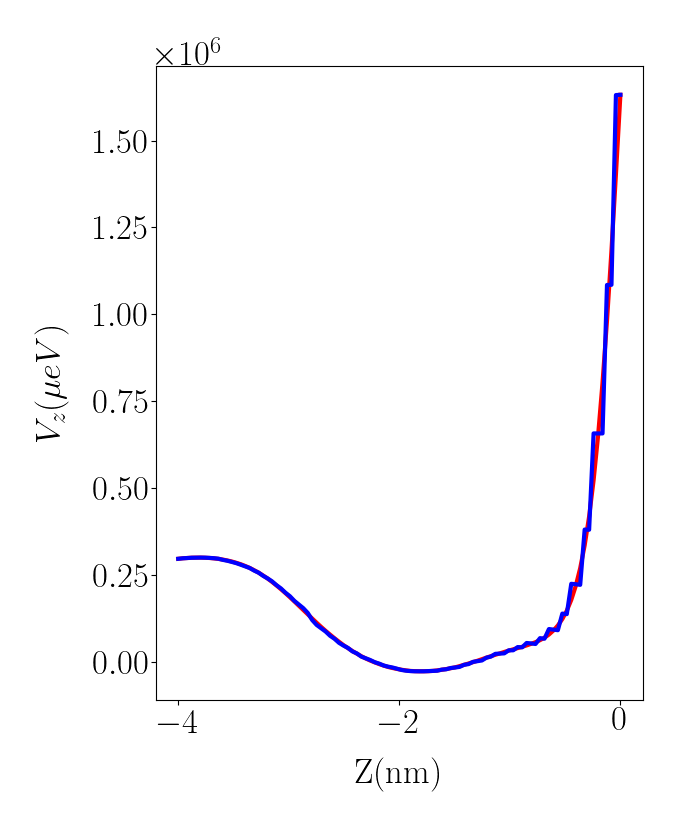

Text(0, 0.5, '$V_z(\\mu eV)$')

In [8]:
pathLenght = 100
min_array = CreateMinArray(pathLenght )
tp = create_TestPath(pathLenght,2)
ps = np.linspace(1,10,10)
fig, ax = plt.subplots(1,1)
ax.plot(tp[2,:], V_hrl(tp),'r')
ax.plot(tp[2,:],ComputePotential(V_HRL, tp, min_array),'b')
ax.set_xlabel('Z(nm)')
ax.set_ylabel('$V_z(\\mu eV)$')

#### 3D plots of HRL potential 

(100,)


<IPython.core.display.Javascript object>


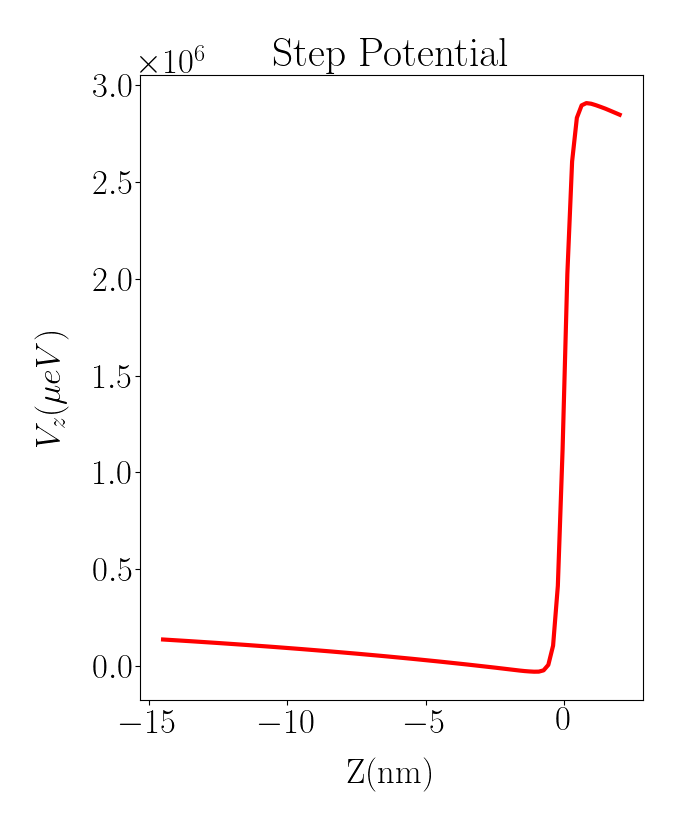

Text(0, 0.5, '$V_z(\\mu eV)$')

In [9]:
Path = np.zeros((3,100))
Path[2,:] = np.linspace(-15,2,100)
print(np.shape(V_hrl(Path)))


V_step(zs)
fig, ax = plt.subplots()
# ax.plot(zs, V_step(zs), 'r')
ax.plot(Path[2,:], V_hrl(Path),'r')
ax.set_title('Step Potential')
ax.set_xlabel('Z(nm)')
ax.set_ylabel('$V_z(\mu eV)$')


<IPython.core.display.Javascript object>


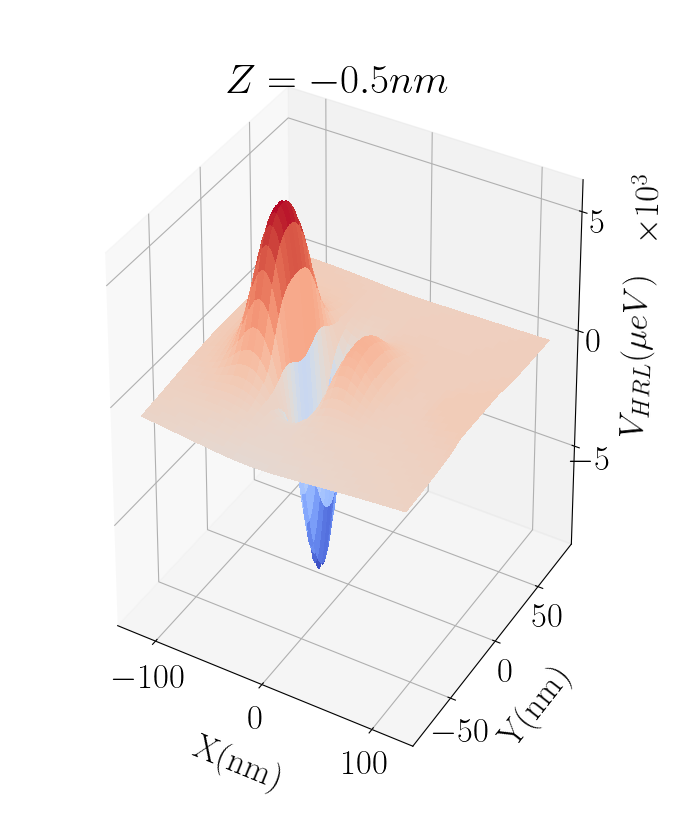

In [10]:
# X, Y plots
def plotXY(GridFunc, z_plane ,xs,ys,zs):
    '''
    Inputs: GridFunc - Function applied over a Grid (xs,ys,zs)-array
            z_plane - plane in the zaxis (z_plane in zs)
            xs,ys,zs - Grid axes
    Return:
    '''
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    X, Y = np.meshgrid(xs, ys)
    Z = GridFunc[:,:,zs == z_plane]
    surf = ax.plot_surface(X, Y, Z[:,:,0].T , cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    
    #Axis Labels
    ax.set_title('$Z =' + np.str(z_plane)+'nm$')
    ax.set_xlabel('X(nm)')
    ax.set_ylabel('Y(nm)')
    ax.set_zlabel('$V_{HRL}(\mu eV)$')
    

# plotXY(V_latt, -2 ,XS,YS,ZS)
# plotXY(ephi, -0.5 ,xs,ys,zs)
#plotXY(V_HRL, -1 ,XS,YS,ZS)

HRL_Potential2 = 'UNSW4_1st withBG TEST ephiQWM for VX1_1V UNSW4_1st structure 2nm 800x800 - 10-4-12-4.npz'
'''Define grid and HRL potential'''
xs = np.load(HRL_Potential2)['xs']
ys = np.load(HRL_Potential2)['ys']
zs = np.load(HRL_Potential2)['zs']
ephi2 = 10**6 * np.load(HRL_Potential2)['ephi']

plotXY(ephi2-ephi, -0.5 ,xs,ys,zs)
# plotXY(ephi, -0.5 ,xs,ys,zs)

<IPython.core.display.Javascript object>


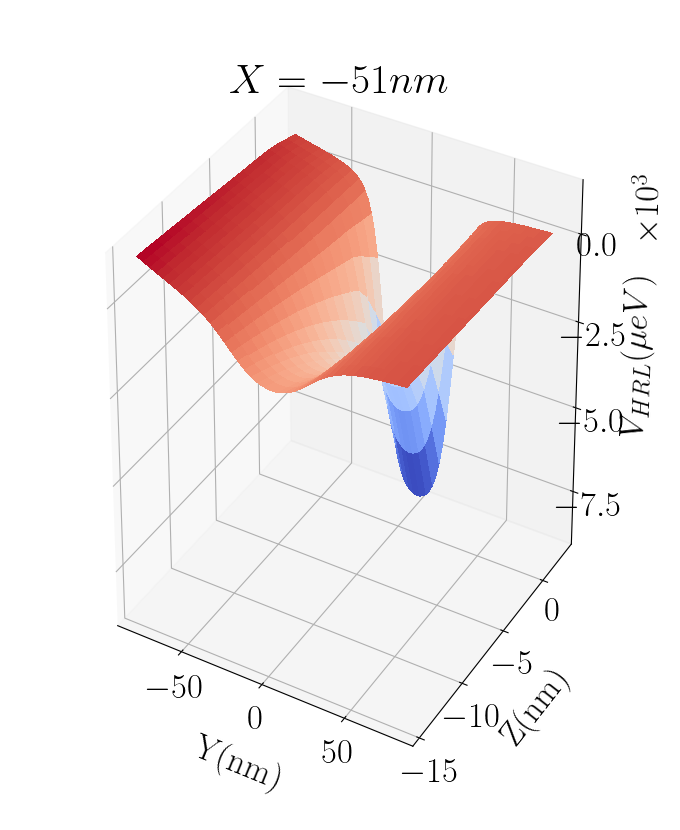

In [11]:
# X, Y plots
def plotYZ(GridFunc, x_plane ,xs,ys,zs):
    '''
    Inputs: GridFunc - Function applied over a Grid (xs,ys,zs)-array
            x_plane - plane in the zaxis (x_plane in xs)
            xs,ys,zs - Grid axes
    Return:
    '''
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    X, Y = np.meshgrid(ys, zs)
    Z = GridFunc[xs == x_plane,:,:]
    surf = ax.plot_surface(X, Y, Z[0,:,:].T , cmap=cm.coolwarm,linewidth=0, antialiased=False)
    
    #Axis Labels
    ax.set_title('$X =' + np.str(x_plane)+'nm$')
    ax.set_xlabel('Y(nm)')
    ax.set_ylabel('Z(nm)')
    ax.set_zlabel('$V_{HRL}(\mu eV)$')
    

# plotXY(ephi2-ephi, -0.5 ,xs,ys,zs)



# y, Z plots
x_plane = -51
plotYZ(ephi-ephi2, -51 ,xs,ys,zs)
# plotYZ(V_latt, -51 ,XS,YS,ZS)
#plotYZ(V_HRL, -51 ,XS,YS,ZS)


<IPython.core.display.Javascript object>


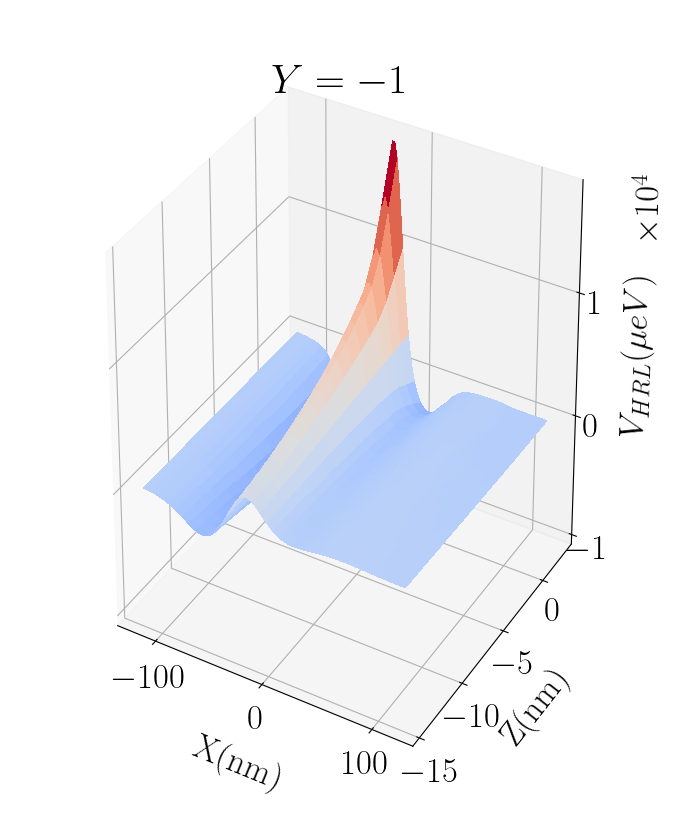

In [12]:
# X, Z plots


def plotYZ(GridFunc,y_plane ,xs,ys,zs):
    '''
    Inputs: GridFunc - Function applied over a Grid (xs,ys,zs)-array
            x_plane - plane in the zaxis (x_plane in xs)
            xs,ys,zs - Grid axes
    Return:
    '''
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    X, Y = np.meshgrid(xs, zs)
    Z = GridFunc[:,ys == y_plane,:]
    surf = ax.plot_surface(X, Y, Z[:,0,:].T , cmap=cm.coolwarm,linewidth=0, antialiased=False)
    
    #Axis Labels
    ax.set_title('$Y =' + np.str(y_plane)+'$')
    ax.set_xlabel('X(nm)')
    ax.set_ylabel('Z(nm)')
    ax.set_zlabel('$V_{HRL}(\mu eV)$')
    

# y_plane = -1.
# fig = plt.figure()
# ax = fig.gca(projection='3d')
# X, Y = np.meshgrid(XS, ZS)
# Z = V_latt[:,YS == y_plane,:]
# surf = ax.plot_surface(X, Y, Z[:,0,:].T , cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)

# # z_label = '$V_{HRL}('+ np.str(y_plane) +')$'
# ax.set_title('$Y =' + np.str(y_plane)+'$')
# ax.set_xlabel('X')
# ax.set_ylabel('Z')
# ax.set_zlabel('$V_{HRL}$  ')





plotYZ(ephi-ephi2, -1 ,xs,ys,zs)
#plotYZ(V_HRL,-1 ,XS,YS,ZS)


#HRL_Potential = 'old_UNSW4_1st withBG TEST ephiQWM UNSW4_1st structure 2nm 800x800 - 10-4-12-4.npz'


In [41]:
def KineticEnergy(MassVec,path):
    '''Computes kinetic energy of path of an electron path
       inputs: MassVec(3*1-array)
               path(3*N-array)
       return: Energy vector(N-array)
    '''
    return (.5/(tau**2))*np.matmul(np.transpose(MassVec),(path[:,1:]-path[:,:-1])**2)
#     return (.5/(4*tau**2))*np.matmul(np.transpose(MassVec),(path[:,2:]-path[:,:-2])**2)

def find_Grid_action(path1,path2,GridFunc, minArray):
    '''Computes the action given two electron paths
       inputs: Path1 , Path2: 3*N-arrays
       outputs: Action(real)
    '''
    #Interaction
    V_interaction = np.sum(ee(path1,path2))
    
    #Kinetic energy
    s1 = tau*KineticEnergy(m,path1)
    s2 = tau*KineticEnergy(m,path2)
    
    #Potential energy
    path1Potential = ComputePotential(GridFunc, path1,minArray)
    path2Potential = ComputePotential(GridFunc, path2,minArray)
    
    #Action
    s1 = np.sum(s1) + tau * np.sum(path1Potential)# + V_interaction
    s2 = np.sum(s2) + tau * np.sum(path2Potential)# + V_interaction
    
    #sum up
    s = s1 + s2  + tau * V_interaction #+ 2 * np.log(2 * np.pi * tau / meff)
    return s


# V_field = V_hrl
# interaction = 1
# def find_action(path1,path2):
#     '''Computes the action given two electron paths
#        inputs: Path1 , Path2: 3*N-arrays
#        outputs: Action(real)
#     '''
#     V_interaction = interaction * np.sum(ee(path1,path2))
    
#     s1 = tau*KineticEnergy(m,path1)
#     s2 = tau*KineticEnergy(m,path2)
    
#     s1 = np.sum(s1) + tau * np.sum(V_field(path1))# + V_interaction
#     s2 = np.sum(s2) + tau * np.sum(V_field(path2))# + V_interaction
    
#     s = s1 + s2 + 2 * np.log(2 * np.pi * tau / meff) + tau * V_interaction
#     return s



    
def KineticTotalEnergy(MassVec,path1,path2, Perm):
    '''Computes kinetic energy of the total periodic path of an electron path
       inputs: MassVec(3*1-array)
               path(3*N-array)
       return: Energy vector(N-array)
    '''
    
    if Perm == 1:
        Rpath1 = np.roll(path1,-1,(1))
        k1 = (.5/(tau**2))*np.matmul(np.transpose(MassVec),(Rpath1-path1)**2)
        
        Rpath2 = np.roll(path2,-1,(1))
        k2 = (.5/(tau**2))*np.matmul(np.transpose(MassVec),(Rpath2-path2)**2)
        return k1 + k2
    
    else:
        BigPath = np.concatenate((path1,path2), axis = 1)
        RBigPath = np.roll(BigPath,-1,(1))
        return (.5/(tau**2))*np.matmul(np.transpose(MassVec),(RBigPath-BigPath)**2)


def find_Grid_Total_action(path1,path2,Perm,GridFunc, minArray):
    '''Computes the action given two electron paths
       inputs: Path1 , Path2: 3*N-arrays
       outputs: Action(real)
    '''
    #Interaction
    V_interaction = interaction * np.sum(ee(path1,path2))
    
    #Kinetic energy
    s1 = tau*KineticTotalEnergy(m,path1,path2, Perm)
    
    #Potential energy
    
    path1Potential = ComputePotential(GridFunc, path1,minArray)
    path2Potential = ComputePotential(GridFunc, path2,minArray)
    
    #Action
    s1 = np.sum(s1) + tau * np.sum(path1Potential) + tau * np.sum(path2Potential)# + V_interaction+ V_interaction
    
    #sum up
    s = s1  + tau * V_interaction #+ 2 * np.log(2 * np.pi * tau / meff)
    return s
    


array([1.08034e-06, 1.08034e-06, 5.57228e-06])

In [19]:
# '''Draft sheet'''
# test_Path1 = create_TestPath(1000,.7)
# test_Path2 = create_TestPath(1000,.8)
# # find_action(test_Path1,test_Path2)
# # interaction


# import time
# start_time = time.time()
# for i in range(10000):
#     find_action(test_Path1,test_Path2)
# print("Value of the action. ----", find_action(test_Path1,test_Path2))
# print("--- %s seconds ---" % (time.time() - start_time))

In [20]:
# '''Draft sheet'''
# pathLenght = 1000
# test_Path1 = create_TestPath(pathLenght,.7)
# test_Path2 = create_TestPath(pathLenght,.8)
# min_array = CreateMinArray(pathLenght)

# V_HRL = ComputeGridFunction(V_hrl, Grid, XS, YS , ZS,False)
# # ComputePotential(V_HRL, generate_path(pathLenght), min_array)


# # find_action(test_Path1,test_Path2)
# # interaction


# # import time
# start_time = time.time()
# for i in range(10000):
#     find_Grid_action(test_Path1,test_Path2,V_HRL,min_array)
# print("Value of the action. ----", find_Grid_action(test_Path1,test_Path2,V_HRL,min_array))
# print("--- %s seconds ---" % (time.time() - start_time))


In [181]:

# stats.hmean([t1,t1],axis = 1)
# np.shape(np.array([t1,t1[-1]-t1])[:,0,:])
timeArr = np.array([t1,t1[:,::-1]])[:,0,:]
stats.hmean(timeArr,axis = 0)
np.matmul(m,harm.T)

NameError: name 'harm' is not defined

In [161]:
t1[:,::-1]


array([[4.999e+03, 4.998e+03, 4.997e+03, ..., 2.000e+00, 1.000e+00,
        0.000e+00]])

In [197]:
def getGaussianDistribution(path,Mvec):
    ''' Sample new path according to the kinetic propagator in the gaussian distribution
     Inputs: path (3*N array) , Mvec(3-array)
     Return: randPath(3*(N-2) arra)

    '''
    init = path[:,0]
    end = path[:,-1]
    T_length = len(path[0,:])
    times = np.linspace(1, T_length-2,T_length-2)
    
    #Reshaping in matrix form for multiplication
    times1 = times.reshape(1,-1) 
    init1 = init.reshape(-1,1) 
    end1 = end.reshape(-1,1) 
    Mvec1 = Mvec.reshape(-1,1)
    
    #harmonic mean for variance computation
    timeArr = np.array([times1,times1[:,::-1]])[:,0,:]
    harm = stats.hmean(timeArr,axis = 0).reshape(-1,1)
    
    
    rmean = (1/T_length)*(np.matmul(init1,times1)+ np.matmul(end1,(times1[:,::-1])) )
    sigma = (tau*hbar**2)*(np.matmul((1/Mvec1),harm.T))
      
#     print(init , end)
#     print(times1[:,::-1] , times1)
    return np.random.normal(rmean, sigma)


newPath = getGaussianDistribution(p1,m)
# getGaussianDistribution(p1)
print(rmean[:,1000] , sigma[:,1000])
# (hbar**2*tau)/m
sigma[:,3]
np.shape(rmean)


newPath[:,0]

[-33.70444657  -0.20742045  -1.82658992] [1284.13008668 1284.13008668  248.9639964 ]


array([-31.98515502,  -1.57570541,  -1.80920528])

In [ ]:
"""
One sweep consists of trying N times changing a random element in the array path (size of this change depends on h),
each time accepting/refusing according to Metropolis. 
"""

def sweepUpdate(path1 , path2):
    '''
    Inputs:
    '''
    init = path1[0]
    end = path1[:-1]
    times = np.array(range(path1))
    
    
    rmean = (1/len(path1))*((times)*init + (times[-1]-times)*end)
    sigma = (hbar**/m)
    
    
    N = len(path1[0,:])
    if np.random.rand(1) > .5:
         # Creating 3N random numbers between [-h/2,h/2]
        rand_r1 = (np.random.rand(3,N)-.5)
        rand_r1[0,:] = h[0]*rand_r1[0,:]
        rand_r1[1,:] = h[1]*rand_r1[1,:]
        rand_r1[2,:] = h[2]*rand_r1[2,:]
        
        rand_r2 = np.zeros((3,N))
    else:
         # Creating 3N random numbers between [-h/2,h/2]
        rand_r2 = (np.random.rand(3,N)-.5)
        rand_r2[0,:] = h[0]*rand_r2[0,:]
        rand_r2[1,:] = h[1]*rand_r2[1,:]
        rand_r2[2,:] = h[2]*rand_r2[2,:]
        
        rand_r1 = np.zeros((3,N))

    #Adding random numbers to create new path 
    new_path1 = path1 + rand_r1
    new_path2 = path2 + rand_r2
            
    return new_path1, new_path2

In [21]:
# path1 = p1
# N = len(path1[0,:])
# randomTime = np.random.randint(N)
# k1 = tau*(.5/(4*tau**2))*np.matmul(np.transpose(m),(path1[:,randomTime]-path1[:,randomTime-1])**2)
# k1

### Experiment with center of mass -like sweeps : 
    1- The implemented algorithm is about a 130 times faster . 
    2- Several implementations need to be taken into account to equiparate it to worm PIMC. The separation of kinetic and potential energy might be crucial for the algorithm to work. This idea is still not considered in this experiment. 
    3- Vectorization and action records have been implemented in the algorithm and are the main actors to explain the increase in efficiency of the algorithm. 
    4- The main idea of the algorithm has changed drastically since the initial implementation, making it difficult to compare it with  the previous implementation. However, previous ideas like spring potentials to force initial convergence might still be implemented. 
    

In [22]:

"""
One sweep consists of trying N times changing a random element in the array path (size of this change depends on h),
each time accepting/refusing according to Metropolis. 
"""

def sweepUpdate(path1 , path2):
    '''
    Inputs:
    '''
    N = len(path1[0,:])
    if np.random.rand(1) > .5:
         # Creating 3N random numbers between [-h/2,h/2]
        rand_r1 = (np.random.rand(3,N)-.5)
        rand_r1[0,:] = h[0]*rand_r1[0,:]
        rand_r1[1,:] = h[1]*rand_r1[1,:]
        rand_r1[2,:] = h[2]*rand_r1[2,:]
        
        rand_r2 = np.zeros((3,N))
    else:
         # Creating 3N random numbers between [-h/2,h/2]
        rand_r2 = (np.random.rand(3,N)-.5)
        rand_r2[0,:] = h[0]*rand_r2[0,:]
        rand_r2[1,:] = h[1]*rand_r2[1,:]
        rand_r2[2,:] = h[2]*rand_r2[2,:]
        
        rand_r1 = np.zeros((3,N))

    #Adding random numbers to create new path 
    new_path1 = path1 + rand_r1
    new_path2 = path2 + rand_r2
            
    return new_path1, new_path2

def exchangeUpdate(Perm ,path1 , path2):
    '''
    Inputs:
    '''
    N = len(path1[0,:])
    randomTime = np.random.randint(N)
    #Computing previous kinetic components at randomTime
    k1 = (.5/(tau))*np.matmul(np.transpose(m),(path1[:,randomTime]-path1[:,randomTime-1])**2)
    k2 = (.5/(tau))*np.matmul(np.transpose(m),(path2[:,randomTime]-path2[:,randomTime-1])**2)
    
    #Computing new kinetic components after exchange at randomTime
    nk1 = (.5/(tau))*np.matmul(np.transpose(m),(path2[:,randomTime]-path1[:,randomTime-1])**2)
    nk2 = (.5/(tau))*np.matmul(np.transpose(m),(path1[:,randomTime]-path2[:,randomTime-1])**2)
    
    delta_s = nk1 + nk2 - k1 - k2
    
    if delta_s < 0: # always accepting if action lowered
        tempPath = np.copy(path1[:,randomTime:])
        path1[:,randomTime:] = np.copy(path2[:,randomTime:])
        path2[:,randomTime:] = np.copy(tempPath)  
        
#         print('Minor action' , np.exp(-(delta_s/hbar) ))
#         print('Sweep accepted -', delta_s )
        return delta_s ,  (-1) * Perm  #permutation variable changes signs

    elif np.random.rand(1) < np.exp(-(delta_s/hbar)): #otherwise accept with PI probability.
#         print('increased with probability ' , np.exp(-(delta_s/hbar) ))
        tempPath = np.copy(path1[:,randomTime:])
        path1[:,randomTime:] = np.copy(path2[:,randomTime:])
        path2[:,randomTime:] = np.copy(tempPath) 
#         print('Sweep accepted +', delta_s )
        return delta_s , (-1) * Perm
        
    else:
#         print('Stable with probability ' , np.exp(-(delta_s/hbar) ))      
        return 0 , Perm
    
    
    
   
    

def sweep(Perm ,path1,path2,GridFunc,min_array,circledPath):
    '''Computes the action given two electron paths
       Inputs: Path1 , Path2: 3*N-arrays
               Sold - old action (float)
       outputs: newPath1, newPath2 (3N-arrays)
                delta_s - difference between new action and old action
    '''
    
    #Old ------ Computing the action
#     So = find_action(path1,path2)   #--- not necessary if the action is saved
#     Sn = find_action(new_path1,new_path2)
    
    new_path1, new_path2 = sweepUpdate(path1 , path2)
    
    So =  find_Grid_action(path1,path2,GridFunc,min_array) #--- not necessary if the action is saved
    Sn =  find_Grid_action(new_path1,new_path2,GridFunc,min_array)
    
    
    #In odd permutations if the paths are crossed and we are sweeping at the boundary, we need to change the kinetic action
    if Perm == -1 & circledPath > -1 :
    #         print(circledPath)
            #substracting kinetic action connecting the same path at the boundary
            So = So - (.5/(tau))*np.matmul(np.transpose(m),(path1[:,circledPath+1]-path1[:,circledPath])**2)
            So = So - (.5/(tau))*np.matmul(np.transpose(m),(path2[:,circledPath+1]-path2[:,circledPath])**2)

            Sn = Sn - (.5/(tau))*np.matmul(np.transpose(m),(new_path1[:,circledPath+1]-new_path1[:,circledPath])**2)
            Sn = Sn - (.5/(tau))*np.matmul(np.transpose(m),(new_path2[:,circledPath+1]-new_path2[:,circledPath])**2)
            
            #adding kinetic action connecting crossing paths at the boundary
            So = So + (.5/(tau))*np.matmul(np.transpose(m),(path1[:,circledPath+1]-path2[:,circledPath])**2)
            So = So + (.5/(tau))*np.matmul(np.transpose(m),(path2[:,circledPath+1]-path1[:,circledPath])**2)

            Sn = Sn + (.5/(tau))*np.matmul(np.transpose(m),(new_path1[:,circledPath+1]-new_path2[:,circledPath])**2)
            Sn = Sn + (.5/(tau))*np.matmul(np.transpose(m),(new_path2[:,circledPath+1]-new_path1[:,circledPath])**2)
        

    delta_s = Sn - So 
#     print(So, Sn , delta_s)          
               
    if delta_s < 0: # always accepting if action lowered
#         print('Minor action' , np.exp(-(delta_s/hbar) ))
        return new_path1 , new_path2 , delta_s
    elif np.random.rand(1) < np.exp(-(delta_s/hbar)): #otherwise accept with PI probability.
#         print('increased with probability ' , np.exp(-(delta_s/hbar) ))
        return new_path1 , new_path2 , delta_s
        
    else:
#         print('Stable with probability ' , np.exp(-(delta_s/hbar) ))      
        return path1 , path2, 0




In [23]:

def ParityOfCrossings(Paths1,Paths2):
    '''
     Inputs: Paths1,Paths2: two collections of paths for the first and secont particles
     Return:Parity of crossings for each pair of paths

    '''
    return -(2*(NumberOfCrossings(Paths1,Paths2)%2)-1) 


def NumberOfCrossings(Paths1,Paths2):
    ''' Returns 
     Inputs: Paths1,Paths2: two collections of paths for the first and secont particles
     Return: Number of crossings for each pair of paths

    ''' 
    Sq = np.sign(Paths1[0,:]-Paths2[0,:])
    BitFunc = np.absolute(Sq[1:]-Sq[:-1])//2
    return np.sum(BitFunc)

In [24]:
10.0 == 10

True

In [61]:

def PIMC(NumRun, pathLength, NumMeasures,T_length, crossings, error):
    '''Excute path integral montecarlo
     Inputs: NumRun (int) - max num runs
             pathLenght - number of time beads
             numMeasures- number of runs between S-measurements
             T_length - lenght of the subpaths used for sweep 
     Return: p1,p2 - Sampled paths
             S_arr - array of measurements

    '''
    
    #Create 2 random paths with definite number of crossings. Perm is the permutation number 
    p1 , p2 , Perm = generate_paths_N_crossings(pathLength, crossings)
    
    S_arr = []
    
    '''The following lines are useful for debugging. They plot paths and 
    '''
    #Paths_1 = []
    #Paths_2 = []
#     fig, axarr = plt.subplots(2,1)

    circledPath = -1 #This variable is used to handle sweeps at the path boundaries with periodic conditions
    exchProb = 0.1 #This variables controls the probability of doing exchange update. Default 0 if not allowed
    
    i = 0
    stop = False
    while (i < NumRun+1) & (stop == False): #there is an stop signal that tells the code if desired
        i = i +1 
        
        '''Execute update half of the cases'''
        if np.random.rand(1) < exchProb:

            deltaS , Perm = exchangeUpdate(Perm, p1 , p2)

        else:

            '''Pic up a T_length-path randomly to sweep'''
            #Select a random time
            rTime = np.random.randint(pathLength)  
            
            
                
                
            #Roll the array to set rTime to the first position
            rolled_p1 = np.roll(p1,-rTime,(1))
            rolled_p2 = np.roll(p2,-rTime,(1))
            #select the first T_length time positions
            pstart1 = rolled_p1[:, :T_length] 
            pstart2 = rolled_p2[:, :T_length] 
            
            #Need to find the bead to eliminate from last position and break imposed periodic boundary conditions
            if (T_length + rTime - 1) > (pathLength):
                circledPath = pathLength - rTime -1
            
            #make sweep only with the fist T components in the array
            pp1 , pp2 , deltaS = sweep(Perm, pstart1, pstart2 ,V_HRL, min_array, circledPath)
            
            #Restore circledPath at original value
            circledPath = -1
            
            #update the sweep result
            rolled_p1[:, :T_length] = np.copy(pp1)
            rolled_p2[:, :T_length] = np.copy(pp2)
            #Unroll vector
            p1 = np.copy(np.roll(rolled_p1,rTime,(1)))
            p2 = np.copy(np.roll(rolled_p2,rTime,(1)))


#         '''Saved last 10000 paths - debugging'''
#         #if i> (NumRun - SavedPaths):
#         #    if  np.random.rand(1) < 0.2:
#         #        Paths_1.append(p1)
#         #        Paths_2.append(p2)
            
        '''Take measurements every 10000 operations'''
        if i%NumMeasures == 0:
            S_tot = find_Grid_Total_action(p1,p2,Perm,V_HRL, min_array2)
                
#             S_tot = find_Grid_action(p1,p2,V_HRL,min_array2)
            S_arr.append(S_tot)
            
            if i//NumMeasures > 20:
                s = np.array(S_arr[-20:])
                STD = np.std(s)
                MEAN = np.mean(s)
                
#                 if ((exchProb > 0) & (STD/MEAN < 0.05) ) :
#                     exchProb = 0
#                     print('No more exchange at', i)
                
                if (STD/MEAN < error ):
                    stop = True
                    print('Stopped at i = ', i)
                    
#             print(S_tot, So)
            '''Plots paths'''
#             axarr[0].plot(range(pathLength) , p1[0,:],'-')
#             axarr[1].plot(range(pathLength) , p2[0,:],'-')
    return p1, p2, S_arr , Perm


    #Paths_1 = np.array(Paths_1)
    #Paths_2 = np.array(Paths_2)

    '''Plotting labels -debugging'''
#     axarr[0].set_xlabel('$\\tau$')
#     axarr[0].set_ylabel('$x$')

#     axarr[1].set_xlabel('$\\tau$')
#     axarr[1].set_ylabel('$x$')
    
# print('increased, decreased, stables')
# print(increased, decreased, stables)


#Generating initial conditions, and potentials




MaxRun = 5000000
pathLength = 5000
NumMeasures = 10000
SavedPaths = 10000
T_length = 50
error = .001
tau = 2*10 ** (-6) #ns
h = np.array([1,1,0.1])

start_time = time.time()
# XS, YS , ZS, Grid =  RefineGrid(xs,ys,zs)
# V_HRL = ComputeGridFunction(V_hrl, Grid, XS, YS , ZS,False)


# np.shape(np.load('V_HRL_Grid.npz')['Grid'])
V_HRL_Grid = np.load('V_HRL_Grid.npz')

XS = V_HRL_Grid['XS']
YS = V_HRL_Grid['YS']
ZS = V_HRL_Grid['ZS']
Grid = V_HRL_Grid['Grid']
V_HRL= V_HRL_Grid['V_HRL']
Z_max = np.argmax(ZS)


np.shape(V_HRL)

min_array = CreateMinArray(T_length)
min_array2 = CreateMinArray(pathLength)


p1,p2,S_arr , Perm = PIMC(MaxRun, pathLength, NumMeasures,T_length,0 , error)
print("Parity ----", Perm)
print("Value of the mean energy ----", np.mean(S_arr[-10:])/pathLength, np.std(S_arr[-10:])/pathLength)
print("--- %s seconds ---" % (time.time() - start_time))


Stopped at i =  2300000
Parity ---- 1
Value of the mean energy ---- 2.0025635791859124 0.004893551993282875
--- 610.2997245788574 seconds ---


<IPython.core.display.Javascript object>


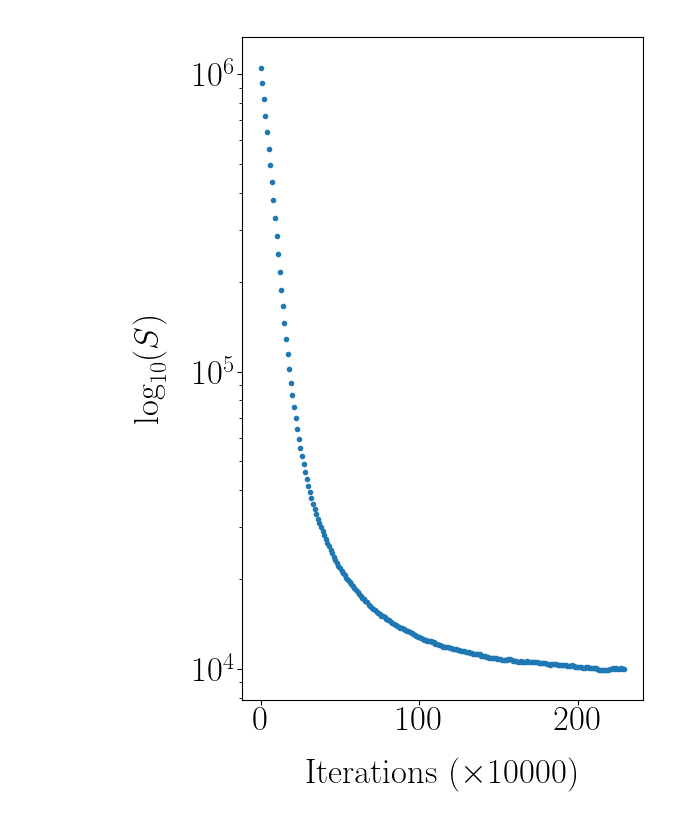

Text(0.5, 0, 'Iterations ($\\times10000$)')

In [62]:

fig, ax = plt.subplots(1,1)
ax.semilogy(range(len(S_arr)),(S_arr),'.')
#Axis Labels
ax.set_ylabel('$\log_{10}(S)$')
ax.set_xlabel('Iterations ($\\times'+ repr(NumMeasures) +'$)')




<IPython.core.display.Javascript object>


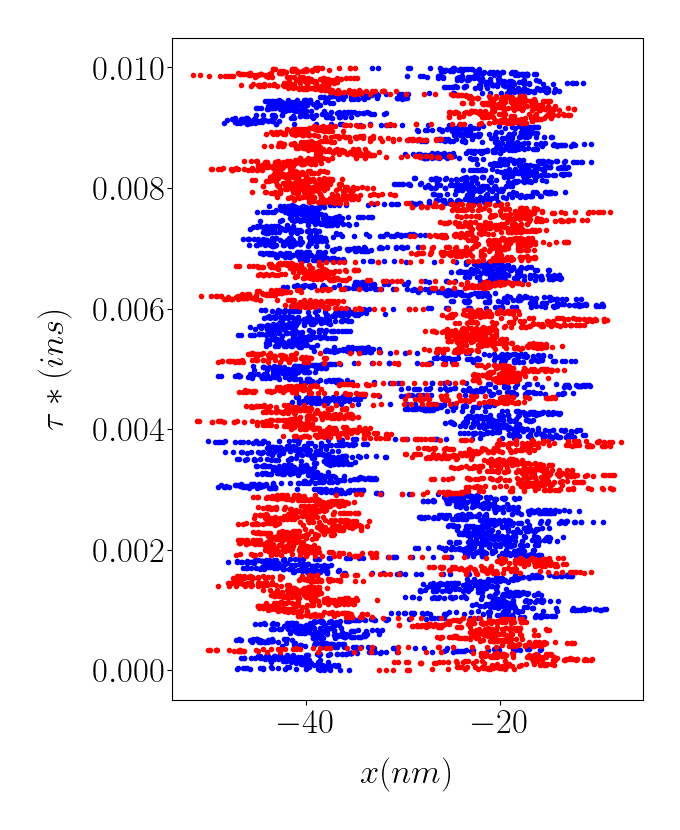

27.0

In [63]:
fig, ax = plt.subplots(1,1)

ax.plot( p1[0,:], np.array(range(pathLength))*tau ,'b.')
ax.plot( p2[0,:], np.array(range(pathLength))*tau ,'r.')

ax.set_ylabel('$\\tau*(ins)$')
ax.set_xlabel('$x (nm)$')
Perm
NumberOfCrossings(p1,p2)

In [77]:
MaxRun = 2000000
pathLength = 6000
NumMeasures = 10000
SavedPaths = 10000
T_length = 60


start_time = time.time()
XS, YS , ZS, Grid =  RefineGrid(xs,ys,zs)
V_HRL = ComputeGridFunction(V_hrl, Grid, XS, YS , ZS,False)
min_array = CreateMinArray(T_length)
min_array2 = CreateMinArray(pathLength)


Paths1 = []
Paths2 = []
Permutations = []
S_mean = []
S_std = []

for i in range(40):
    print('Run ',i)
    p1,p2,S_arr, Perm = PIMC(MaxRun, pathLength, NumMeasures,T_length, i,0.01)
    
    Paths1.append(p1)
    Paths2.append(p2)
    S_mean.append(np.mean(S_arr[-10:]))
    S_std.append(np.std(S_arr[-10:]))
    Permutations.append(Perm)
    print('S = ', S_arr[-1])

Paths1 = np.array(Paths1)
Paths2 = np.array(Paths2)
S_mean = np.array(S_mean)
S_std  = np.array(S_std)
Permutations = np.array(Permutations)    

np.save('Paths/10Paths1', Paths1 )
np.save('Paths/10Paths2', Paths2 )
np.save('Paths/10Permutations', Permutations )
np.save('Paths/10S_mean', S_mean )
np.save('Paths/10S_std', S_std )

Run  0
Stopped at i =  1390000
S =  10863.75340352523
Run  1
Stopped at i =  1480000
S =  10860.997095209475
Run  2
Stopped at i =  1370000
S =  10985.528055284252
Run  3
Stopped at i =  1370000
S =  10968.247815637991
Run  4
Stopped at i =  1490000
S =  10602.85766338781
Run  5
Stopped at i =  1430000
S =  10716.796719261507
Run  6
Stopped at i =  1420000
S =  10980.852596198998
Run  7
Stopped at i =  1220000
S =  11344.80083676102
Run  8
Stopped at i =  1350000
S =  11253.278289661217
Run  9
Stopped at i =  1440000
S =  10859.833255169906
Run  10
Stopped at i =  1400000
S =  10946.605474959957
Run  11
Stopped at i =  1370000
S =  10909.577959314749
Run  12
Stopped at i =  1370000
S =  10927.8276560298
Run  13
Stopped at i =  1470000
S =  10724.659246621512
Run  14
Stopped at i =  1320000
S =  10915.041157014412
Run  15
Stopped at i =  1470000
S =  10791.526403156924
Run  16
Stopped at i =  1520000
S =  10558.496802290398
Run  17
Stopped at i =  1340000
S =  11097.380272887005
Run  18

In [ ]:
MaxRun = 2000000
pathLength = 6000
NumMeasures = 10000
SavedPaths = 10000
T_length = 60

XS, YS , ZS, Grid =  RefineGrid(xs,ys,zs)
V_HRL = ComputeGridFunction(V_hrl, Grid, XS, YS , ZS,False)
min_array = CreateMinArray(T_length)
min_array2 = CreateMinArray(pathLength)

MAX_Workers = 2
Number_Samples = 2
print('Executing PIMC')
'''Executing PIMC on multiple machines'''
Ps = []
with ThreadPoolExecutor(max_workers=MAX_Workers) as executor:
    returns = [executor.submit(PIMC,MaxRun, pathLength, NumMeasures,T_length, i) for i in range(Number_Samples)]
    for r in concurrent.futures.as_completed(returns):
        Ps.append(r.result())
        
        
print('Processing and saving results')
'''Processing results'''
Ps = np.array(Ps)

#Creating arrays 
Paths1 = np.array(Ps[:,0])
Paths2 = np.array(Ps[:,1])
SARR= Ps[:,2]
PERM= np.array(Ps[:,3])


P1 = np.zeros((len(Paths1),3,pathLength))
P2 = np.zeros((len(Paths1),3,pathLength))
SS = np.zeros(len(SARR))
SSTD = np.zeros(len(SARR))
for i in range(len(Paths1)):
    P1[i,:,:] = Paths1[i]
    P2[i,:,:] = Paths2[i]
    Si = np.array(SARR[i])
    SS[i] = np.mean(Si[-10:])
    SSTD[i] = np.std(Si[-10:])
    
#Creating name files
nm1 = repr(Number_Samples) + 'Paths1'
nm2 = repr(Number_Samples) + 'Paths2'
nmS = repr(Number_Samples) + 'S_mean'
nmStd = repr(Number_Samples) + 'S_std'
nmPerm =  repr(Number_Samples) + 'Perms'


'''Saving results in the Paths folder'''
np.save(nm1, P1 )
np.save(nm2, P2 )
np.save(nm2, SS )
np.save(nm2, SSTD )
np.save(nm2, PERM )

In [ ]:
np.shape(P1)

In [ ]:
np.shape(P1)

In [ ]:

p1_mean = np.mean(Paths_1[:,0,:],1)
print('Dot1- mean, std')
print(np.mean(p1_mean) , np.std(p1_mean))


p2_mean = np.mean(Paths_2[:,0,:],1)
print('Dot1- mean, std')
print(np.mean(p2_mean) , np.std(p2_mean))

np.shape(Paths_1)


In [ ]:
# Paths_2[0,:,:]

In [ ]:
# print(np.max(Paths_1[:,0,:]),np.argmin(Paths_2[:,0,:],1))

# bools = Paths_1[:,0,:] > Paths_2[:,0,:]

# for i in range(len(Paths_1[:,0,0])):
#     for j in range(len(Paths_1[0,0,:])):
#         if bools[i,j]:
#             print(i,j)
# bools

In [ ]:
%ls
%pwd

In [ ]:
P1 = np.load('Paths/HundredPaths1.npy')
P2 = np.load('Paths/HundredPaths2.npy')

fig, ax = plt.subplots(1,1)

for NP in np.random.randint(len(P1[:,0,0]),size = 1 ): 
#for NP in range(len(P1[:,0,0])):
    print(NP)
    ax.plot(P1[NP,0,:], range(len(P1[NP,0,:])) , '-')
    ax.plot(P2[NP,0,:], range(len(P1[NP,0,:])),':')

np.shape(P1)


In [ ]:


start_time = time.time()

def ThrowRandom():
    '''
     Inputs:
     Return:

    '''
    return np.random.randint(2,size = 100000)
# print(ThrowRandom())


from multiprocessing import Pool


Ps = []



# # print("Value of the action. ----", S_arrs[-20:])
# print("--- %s seconds ---" % (time.time() - start_time))
ThrowRandom()

In [ ]:
start_time = time.time()
Ps = []
for _ in range(10000):
    Ps.append(ThrowRandom())
print("--- %s seconds ---" % (time.time() - start_time))
np.shape(np.array(Ps))

In [ ]:

def main():
    
    '''Defining montecarlo variables'''
    MAX_Workers = 10 # Max number of procesors
    Number_Samples = 2 #Number of paths to sample
    
    MaxRun = 10**6 #Maximum number of runs --- tipically 10**6 for a 1000 path
    pathLength = 10**3 #Path Lenght in time slices
    #Meaurements are executed in order to probe if the code has already converged
    NumMeasures = 10**4 #Number of times between measurements . Two orders of magnitude less than MaxRun
    T_length = 20 # lenght of the time slice moved at each sweep update. 
                  #T_lenght should have 2 orders of magnitude less than pathLenght for better efficiency
    
    
    '''Set up model parameters
    Parameters, units: ueV, nm, ns'''
    
    print('Setting initial constants')
    #beta = 0.1 # imaginary total time? (/hbar?)
    tau = 10 ** (-6) #ns
    interaction = 1 # Turn on/off electron-electron interaction (1 or 0)
    h= np.array([1,.7,.08]) # nm random displacement vector
    eec = 1.23*10**5 # ueV electron electron coupling constant
    me = 5.686 * 10 **(-6) # ueV ns^2/nm^2 - electron mass
    mass = 1 # Effective mass on/off
    if mass == 1:
            meff= 0.2 * me #effective electron mass in Silicon
            ml = 0.98 * me #effective mass in longitudinal k-direction
            mt = 0.19 * me #effective mass in transverse k-direction
            mx = mt #effective mass in x-direction
            my = mt #effective mass in y-direction
            mz = ml #effective mass in z-direction
            m = np.array([mx,my,mz])
            print('Effective mass vector (m) = ', m,'*me' )
    else:
            print('No Mass')
    pot_step = 3 * 10**6 #ueV - Si/SiO2 interfac
    hbar = 0.6582 # ueV * ns
    a = 0.543 #nm - lattice constant in silicon
    w = 4000/hbar
    q = 10**6 # ueV
    lamda = 0.5 * hbar**2 / me
    r_0 = np.sqrt(hbar / (me*w))
    E_z = 2 * 10**3 #ueV/nm - Electric field in z direction
    slope = E_z
    V = pot_step
    x_0 = 1.5*r_0
    V_field = V_hrl
    
    print('tau = ', tau, '(ns)')
    print('Displacement vector (h) =', h , 'nm')
    print('Electron-electron coupling constant (eec) =', eec, 'ueV')
    print('me = ', repr(np.round(me,9)), 'ueV*ns^2/nm^2' )
    print('Step voltage height (pot_step) = ', pot_step,' $ueV$' )
    print('Lattice constant (a)=', a, 'nm')
    
    print('Defining potentials and setting up look up tables')
    
    
    '''Define grid and uploading HRL potential'''
    xs = np.load('UNSW4_1st withBG TEST ephiQWM UNSW4_1st structure 2nm 800x800 - 10-4-12-4.npz')['xs']
    ys = np.load('UNSW4_1st withBG TEST ephiQWM UNSW4_1st structure 2nm 800x800 - 10-4-12-4.npz')['ys']
    zs = np.load('UNSW4_1st withBG TEST ephiQWM UNSW4_1st structure 2nm 800x800 - 10-4-12-4.npz')['zs']
    ephi = 10**6 * np.load('UNSW4_1st withBG TEST ephiQWM UNSW4_1st structure 2nm 800x800 - 10-4-12-4.npz')['ephi']

    interpolate = rgi(points = (xs,ys,zs), values = ephi, bounds_error = False, method = 'linear') #options 'linear' , 'nearest'

    '''Defining potentials and Grid look-up tables'''
    
    XS, YS , ZS, Grid =  RefineGrid(xs,ys,zs)
    V_HRL = ComputeGridFunction(V_hrl, Grid, XS, YS , ZS,False)
    min_array = CreateMinArray(T_length)
    min_array2 = CreateMinArray(pathLength)
    

            
    



In [ ]:
main()

In [ ]:
S_ARR = np.array(Ps[:,2])
len(S_ARR[1])

In [ ]:
A = Ps[1]
P1 = A[0]
P2 = A[1]

fig, ax = plt.subplots(1,1)


# for NP in range(len(P1[:,0,0])):
ax.plot(P1[0,:], range(len(P1[0,:])) , '-')
ax.plot(P2[0,:], range(len(P1[0,:])),':')


In [ ]:

"""
Multiprocessing for sending to NCI computer, tried splitting up the jobs to different CPUs but job is 'embarrasingly parallel'
"""

pool = mp.Pool()
#pool1 = mp.Pool()
#pool2 = mp.Pool()

actions = pool.map(find_pederson_actions, [N for N in N_list]) # should in theory return crossing & staying action for each N
#stayingactions = pool2.map(find_staying_actions, [N for N in N_list])
#crossingactions = pool1.map(find_crossing_actions, [N for N in N_list])

pool.close()
#pool1.close()
#pool2.close()

# %%
"""
If using single pool, use this to extract seperate actions from final result
"""
#crossing_action_list = list(actions[i][0] for i in range(len(actions)))
#staying_action_list = list(actions[i][1] for i in range(len(actions)))

# %%

action_ratio_list = np.divide(crossing_action_list,staying_action_list)

def exchange_coupling():
    print(int(len(N_list)/4))
    slope = linregress(N_list[-int(len(N_list)/4):],action_ratio_list[-int(len(N_list)/4):])[0]
    J = slope / tau
    print('J = ',J,'(ueV)')
    print('J = ',J/hbar,'(GHz)')

exchange_coupling()

# %%
plt.plot(N_list,np.log(action_ratio_list),'.-')
plt.xlabel('N')
plt.ylabel('$ln(S_X/S_{||})$')
#plt.ylim(-0.1,0.1)
plt.show()